# Week 00

**Goal**: Foundation - Math + Autograd engine from scratch

#### Core (MVP) - 4-5 days
- [ ] **Math refresher** (see [Math Refresher](#math-refresher) section):
  - Linear algebra: shapes, matmul, broadcasting, SVD intuition
  - Calculus: chain rule, gradients, backprop
  - Optimization: SGD, Adam, AdamW update rules
  - Probability: softmax, cross-entropy, KL divergence
- [x] **Micrograd**: Build autograd engine (Karpathy video)
  - Value class with \_\_add\_\_, \_\_mul\_\_, etc.
  - Topological sort for backward pass
  - Train tiny MLP on toy dataset
- [x] **Deliverable**: `autograd.py` (100 lines), gradient checker, math cheat sheet

#### Stretch - 2 days
- [ ] Makemore part 1: Bigram character model
- [ ] Makemore part 2: MLP character predictor
- [ ] Read: *Attention Is All You Need* (skim)

#### Mega-stretch - 2 days
- [ ] Implement BatchNorm from scratch
- [ ] Numerical stability debugging toolkit
- [ ] Gradient visualization tool

#### Metrics
- None yet (foundation week)

#### Resources
- Karpathy NN:0→Hero Lecture 1 (micrograd)
- 3Blue1Brown: Linear Algebra + Calculus essentials
- Matrix Cookbook (reference)


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', label=f"{self.label}+{other.label}")
        
        # when _op="+", we pass the grad value of parents to its children
        def _backward():
            # Gradients should accumulate if variables are used more than once
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other): # -> other * self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        # when _op="*", children take each others data values
        # multiplied by parent's grad value
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # -> other * self
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # do/dn = 1 - tanh(n)**2 = 1-o**2
            self.grad = (1 - out.data**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):   
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for v in reversed(topo):
            v._backward()

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [4]:
# Graph Visualization
from graphviz import Digraph

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


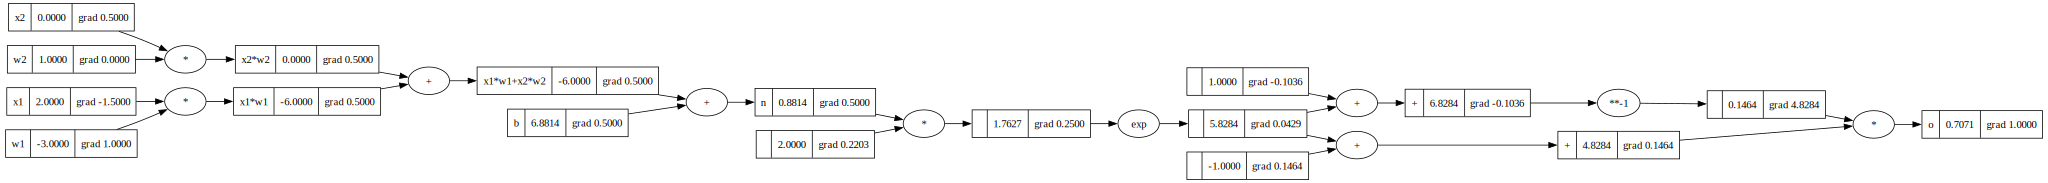

In [5]:
# Set values

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [6]:
# PyTorch implementation

import torch
import random


x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [21]:
import random
from micrograd.grad import Value

class Neuron:

    def __init__(self, nin):
        self.w = [(Value(random.uniform(-1, 1))) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b).tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout): # nout -> number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            neuron_params = neuron.parameters()
            params.extend(neuron_params)
        return params

class MLP:

    def __init__(self, nin, nouts): # nouts -> list of nouts, nout_i is number of neurons for layer_i
        size = [nin] + nouts # [nin, nout_0, nout_1, ...] -> layer_0's outputs are layer_1's inputs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            layer_params = layer.parameters()
            params.extend(layer_params)
        return params


In [ ]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
nn = mlp(x)


In [27]:
mlp.parameters()

[Value(data=-0.12339814397744853),
 Value(data=0.33231525484370583),
 Value(data=-0.4654679963901871),
 Value(data=-0.31940711653810183),
 Value(data=0.41493345933070636),
 Value(data=0.027611425415461355),
 Value(data=-0.29932507840350264),
 Value(data=-0.05582670363592945),
 Value(data=-0.2850714748028851),
 Value(data=0.1932842178782943),
 Value(data=0.14518945446706155),
 Value(data=-0.5654070729614971),
 Value(data=0.10572186341735867),
 Value(data=-0.9308124933019111),
 Value(data=-0.33169773935678726),
 Value(data=-0.7671871360649796),
 Value(data=-0.9486708426878461),
 Value(data=0.14846659787512695),
 Value(data=-0.9518571449220905),
 Value(data=0.48989609743647944),
 Value(data=0.4561927955456955),
 Value(data=-0.6695976289629608),
 Value(data=-0.9146160291124217),
 Value(data=-0.04734133272203955),
 Value(data=0.5391946661130698),
 Value(data=0.9628969775518099),
 Value(data=-0.12261614895429762),
 Value(data=0.1497320882054447),
 Value(data=-0.5443838743357807),
 Value(data

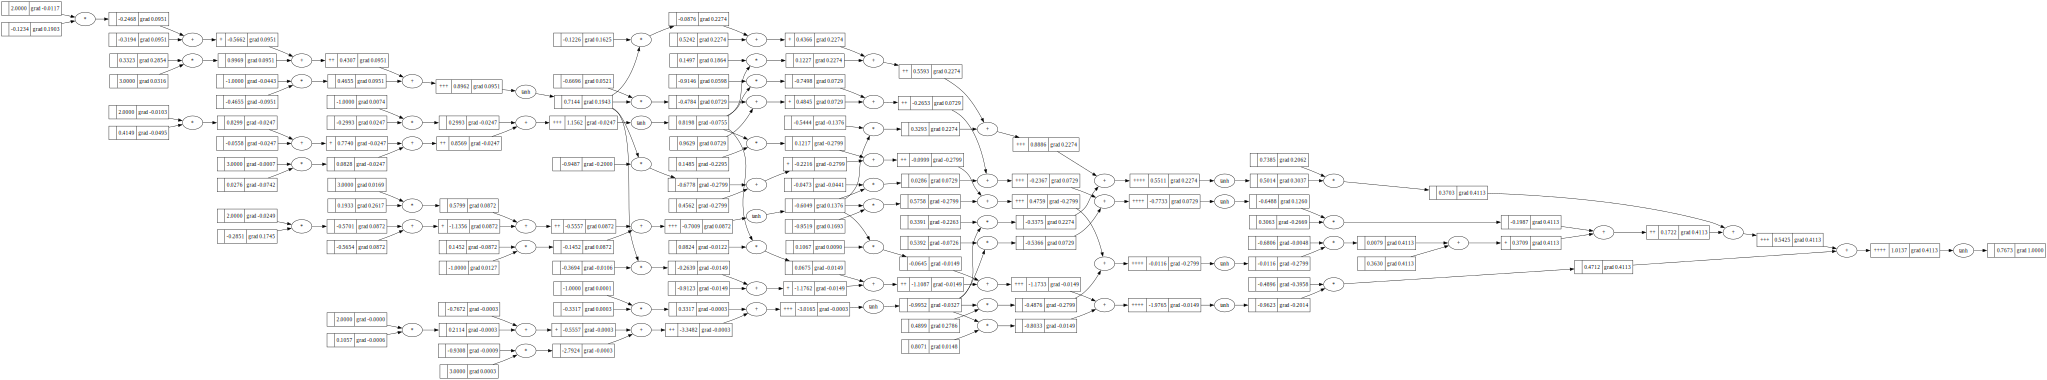

In [29]:
nn.backward()
draw_dot(nn)

In [30]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.7672675025178356),
 Value(data=0.6389564837942072),
 Value(data=0.7139047501333352),
 Value(data=0.7123644689647628)]

In [19]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss.backward()